# Twitter Sentiment Analysis from datatset

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/nlp/twi.png" width="600">


In [60]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import os
import nltk
# import spacy
import random
# from spacy.util import compounding
# from spacy.util import minibatch

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score


In [61]:
!pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


**Below is a helper Function which generates random colors which can be used to give different colors to your plots.Feel free to use it**

In [62]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

# Reading the Data

In [63]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/nlp/twitter.csv

--2021-05-06 08:51:25--  https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/nlp/twitter.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.149.138
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.149.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3501243 (3.3M) [text/csv]
Saving to: ‘twitter.csv.2’

twitter.csv.2       100%[===================>]   3.34M  --.-KB/s    in 0.09s   

2021-05-06 08:51:25 (37.2 MB/s) - ‘twitter.csv.2’ saved [3501243/3501243]



In [64]:
df = pd.read_csv('twitter.csv')

In [65]:
df.dropna(inplace=True)
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


# EDA

In [66]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


Selected_text is a subset of text 

In [67]:
df.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,10c1f302a6,i am having serious problems concentrating on ...,good,neutral
freq,1,1,199,11117


Lets look at the distribution of tweets in the dataset

In [68]:
temp = df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)

temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


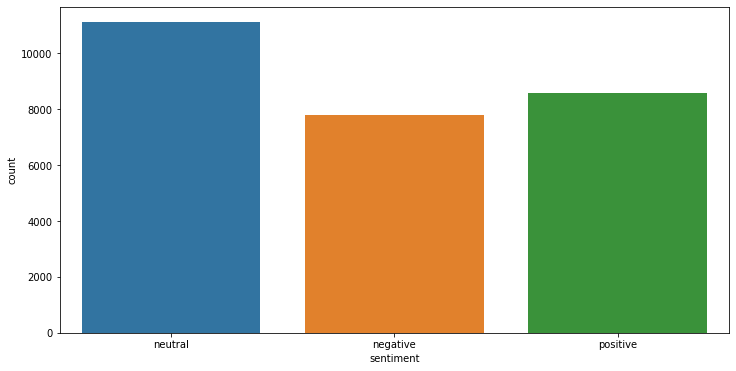

In [69]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df);

In [70]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

### Cleaning the Corpus
Now Before We Dive into extracting information out of words in text and selected text,let's first clean the data

In [71]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [72]:
df['text'] = df['text'].apply(lambda x:clean_text(x))
df['selected_text'] = df['selected_text'].apply(lambda x:clean_text(x))

In [73]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative
2,088c60f138,my boss is bullying me,bullying me,negative
3,9642c003ef,what interview leave me alone,leave me alone,negative
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on denver husband l...,d lost,negative
27477,4f4c4fc327,ive wondered about rake to the client has ma...,dont force,negative
27478,f67aae2310,yay good for both of you enjoy the break you...,yay good for both of you,positive
27479,ed167662a5,but it was worth it,but it was worth it,positive


## Most Common words in our Target-Selected Text

In [74]:
df['temp_list'] = df['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,i,7200
1,to,5305
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


In [75]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

OOPS!While we cleaned our dataset we didnt remove the stop words and hence we can see the most coomon word is 'to' . Let's try again after removing the stopwords

In [76]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [77]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]

In [78]:
df['temp_list2'] = df['temp_list'].apply(lambda x:remove_stopword(x))
df

,textID,text,selected_text,sentiment,temp_list,temp_list2
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,"[id, have, responded, if, i, were, going]","[id, responded, going]"
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,"[sooo, sad]","[sooo, sad]"
2,088c60f138,my boss is bullying me,bullying me,negative,"[bullying, me]",[bullying]
3,9642c003ef,what interview leave me alone,leave me alone,negative,"[leave, me, alone]","[leave, alone]"
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,"[sons, of]",[sons]
...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on denver husband l...,d lost,negative,"[d, lost]",[lost]
27477,4f4c4fc327,ive wondered about rake to the client has ma...,dont force,negative,"[dont, force]","[dont, force]"
27478,f67aae2310,yay good for both of you enjoy the break you...,yay good for both of you,positive,"[yay, good, for, both, of, you]","[yay, good]"
27479,ed167662a5,but it was worth it,but it was worth it,positive,"[but, it, was, worth, it]",[worth]


In [79]:
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,to,5305
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986
10,for,1854


# Most Common words in Text

Let's also look at the most common words in Text

In [80]:
df['temp_list1'] = df['text'].apply(lambda x:str(x).split()) #List of words in every row for text
df['temp_list1'] = df['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [81]:
top = Counter([item for sublist in df['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


So the first two common word was I'm so I removed it and took data from second row

In [82]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

SO we can see the Most common words in Selected text and Text are almost the same,which was obvious

# Most common words Sentiments Wise

Let's look at the most common words in different sentiments

In [83]:
Positive_sent = df[df['sentiment']=='positive']
Negative_sent = df[df['sentiment']=='negative']
Neutral_sent = df[df['sentiment']=='neutral']

In [84]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,i,1040
1,good,826
2,happy,730
3,love,697
4,you,623
5,to,608
6,a,589
7,the,571
8,day,456
9,thanks,439


In [85]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [86]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,to,594
2,the,547
3,my,524
4,a,472
5,im,452
6,not,407
7,is,373
8,so,360
9,miss,358
10,sad,343


In [87]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

In [88]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,to,4103
2,the,3472
3,a,2477
4,my,1971
5,and,1800
6,you,1760
7,in,1574
8,it,1476
9,is,1470
10,for,1406


In [89]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [90]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

* We can see words like get,go,dont,got,u,cant,lol,like are common in all three segments . That's interesting because words like dont and cant are more of negative nature and words like lol are more of positive nature.Does this mean our data is incorrectly labelled , we will have more insights on this after N-gram analysis
* It will be interesting to see the word unique to different sentiments

## Let's Look at Unique Words in each Segment

We will look at unique words in each segment in the Following Order:
* Positive
* Negative
* Neutral

In [91]:
raw_text = [word for word_list in df['temp_list1'] for word in word_list]

In [92]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in df[df_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in df[df.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in df[df.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

### Positive Tweets

In [93]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,shared,7
4,presents,7
5,greetings,7
6,blessings,6
7,mothersday,6
8,mcr,6
9,coolest,6


In [94]:
fig = px.treemap(Unique_Positive, path=['words'], values='count',title='Tree Of Unique Positive Words')
fig.show()

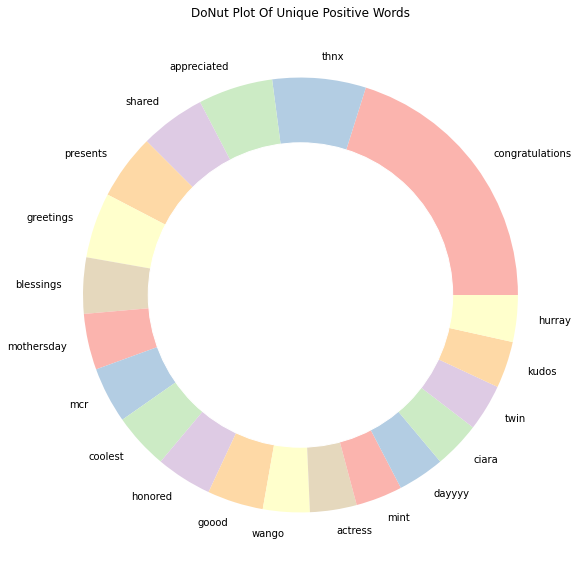

In [95]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

In [96]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,ache,12
1,suffering,9
2,allergic,7
3,cramps,7
4,saddest,7
5,pissing,7
6,sob,6
7,dealing,6
8,devastated,6
9,noes,6


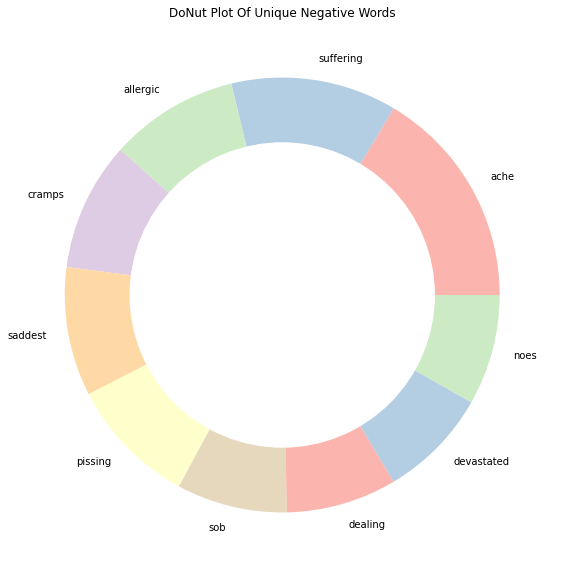

In [97]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Negative Words')
plt.show()

In [98]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,settings,9
1,explain,7
2,mite,6
3,hiya,6
4,reader,5
5,pr,5
6,sorta,5
7,fathers,5
8,enterprise,5
9,guessed,5


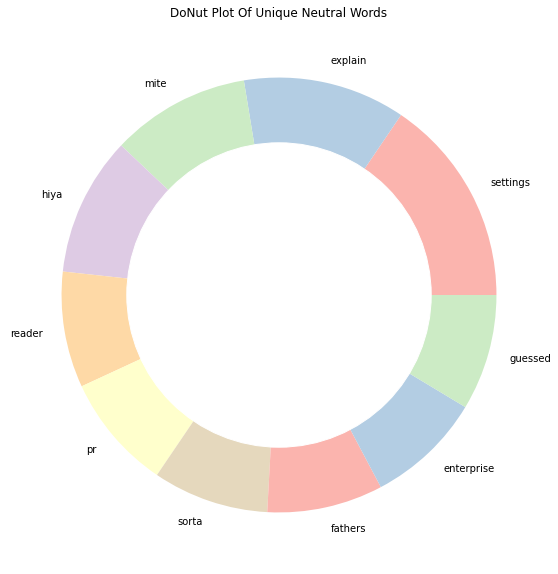

In [99]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Neutral Words')
plt.show()

**By Looking at the Unique Words of each sentiment,we now have much more clarity about the data,these unique words are very strong determiners of Sentiment of tweets**

## It's Time For WordClouds

We will be building wordclouds in the following order:

* WordCloud of Neutral Tweets
* WordCloud of Positive Tweets
* WordCloud of Negative Tweets


In [100]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

#### WORDCLOUD OF NEUTRAL TWEETS

We Have already visualized our Most Common Negative words ,but Wordclouds Provide us much more clarity

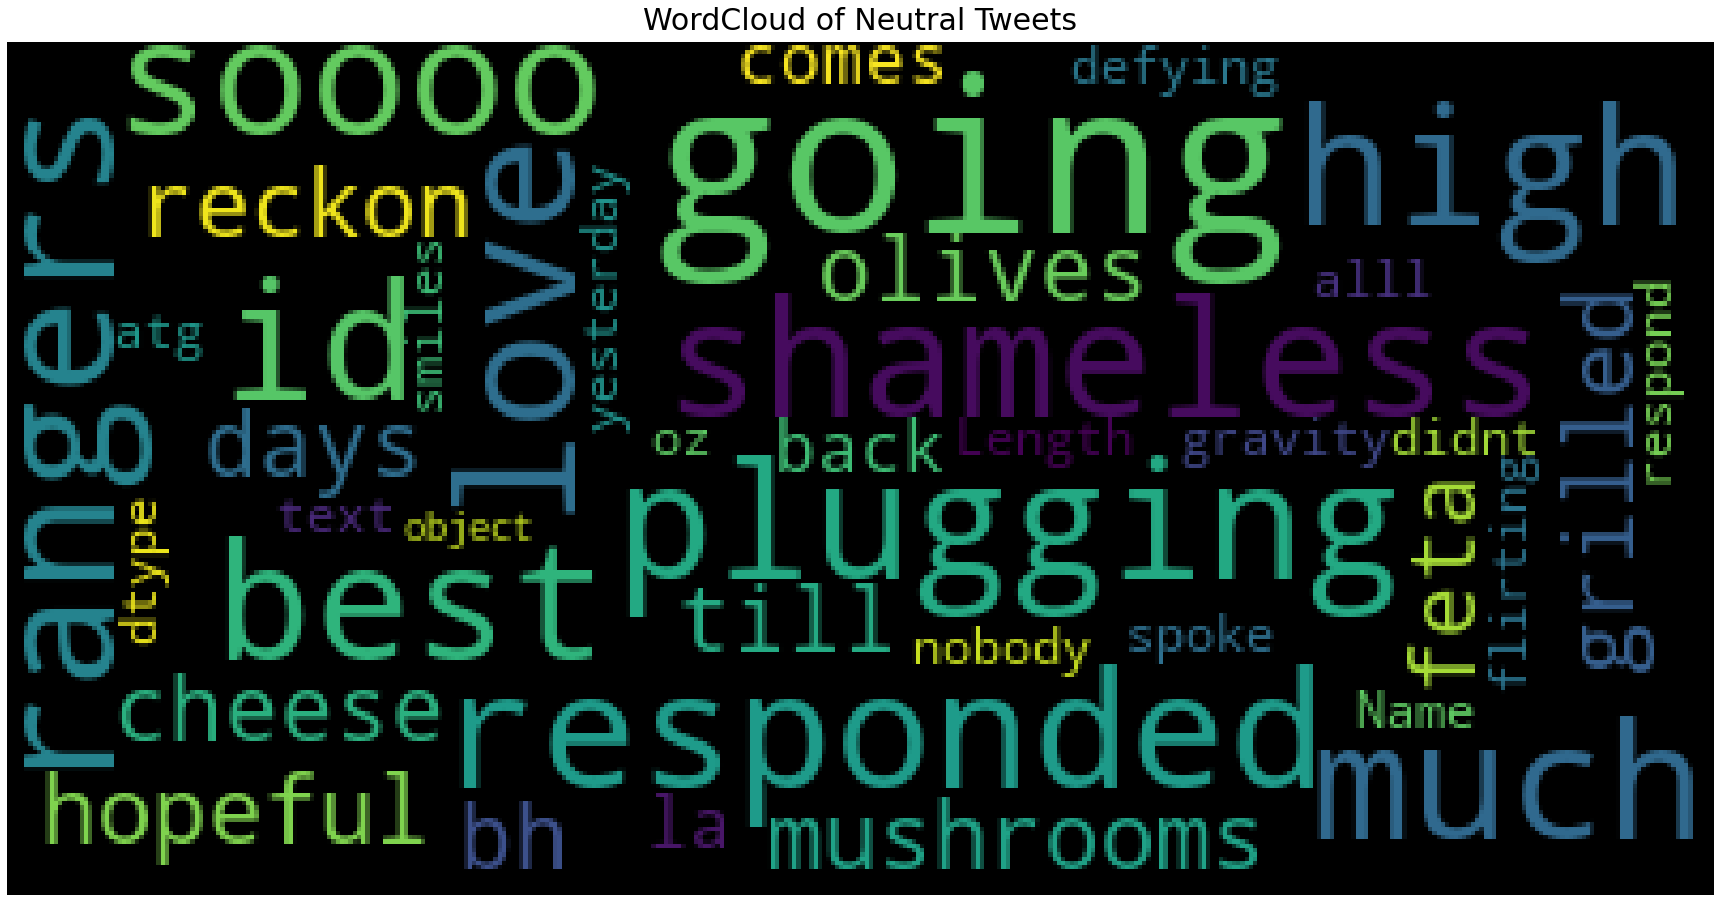

In [101]:
#pos_mask = np.array(Image.open('twitter_mask.png'))
plot_wordcloud(Neutral_sent.text,color='black',max_font_size=50,title_size=30,title="WordCloud of Neutral Tweets")

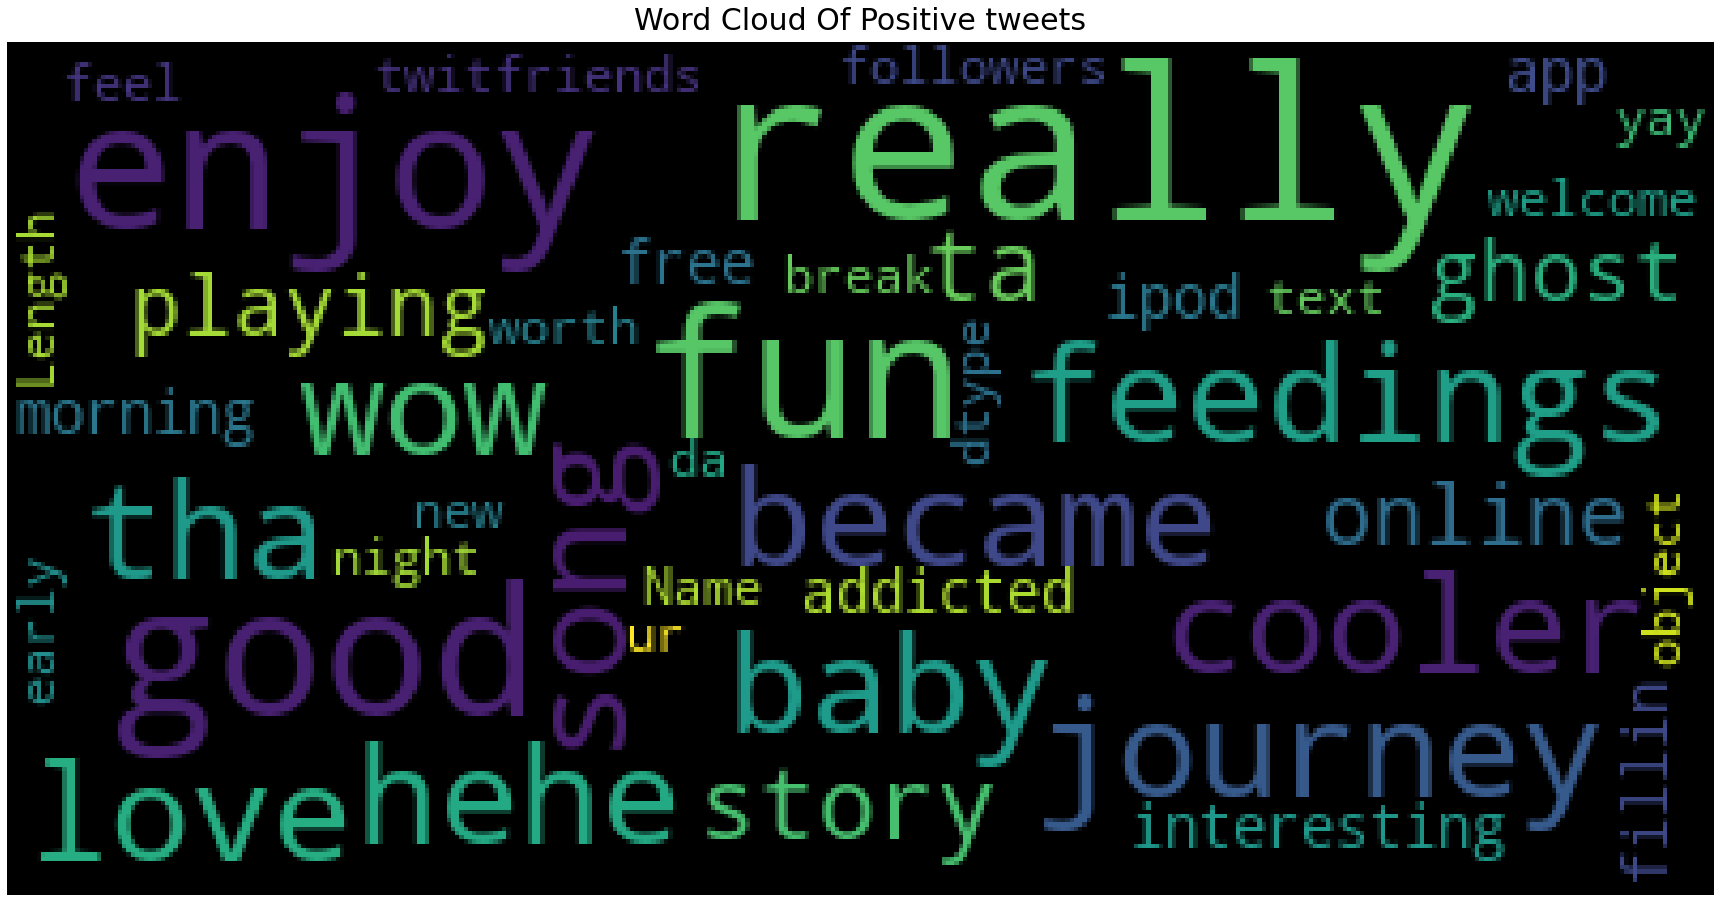

In [102]:
plot_wordcloud(Positive_sent.text,color='black',max_font_size=50,title="Word Cloud Of Positive tweets",title_size=30)

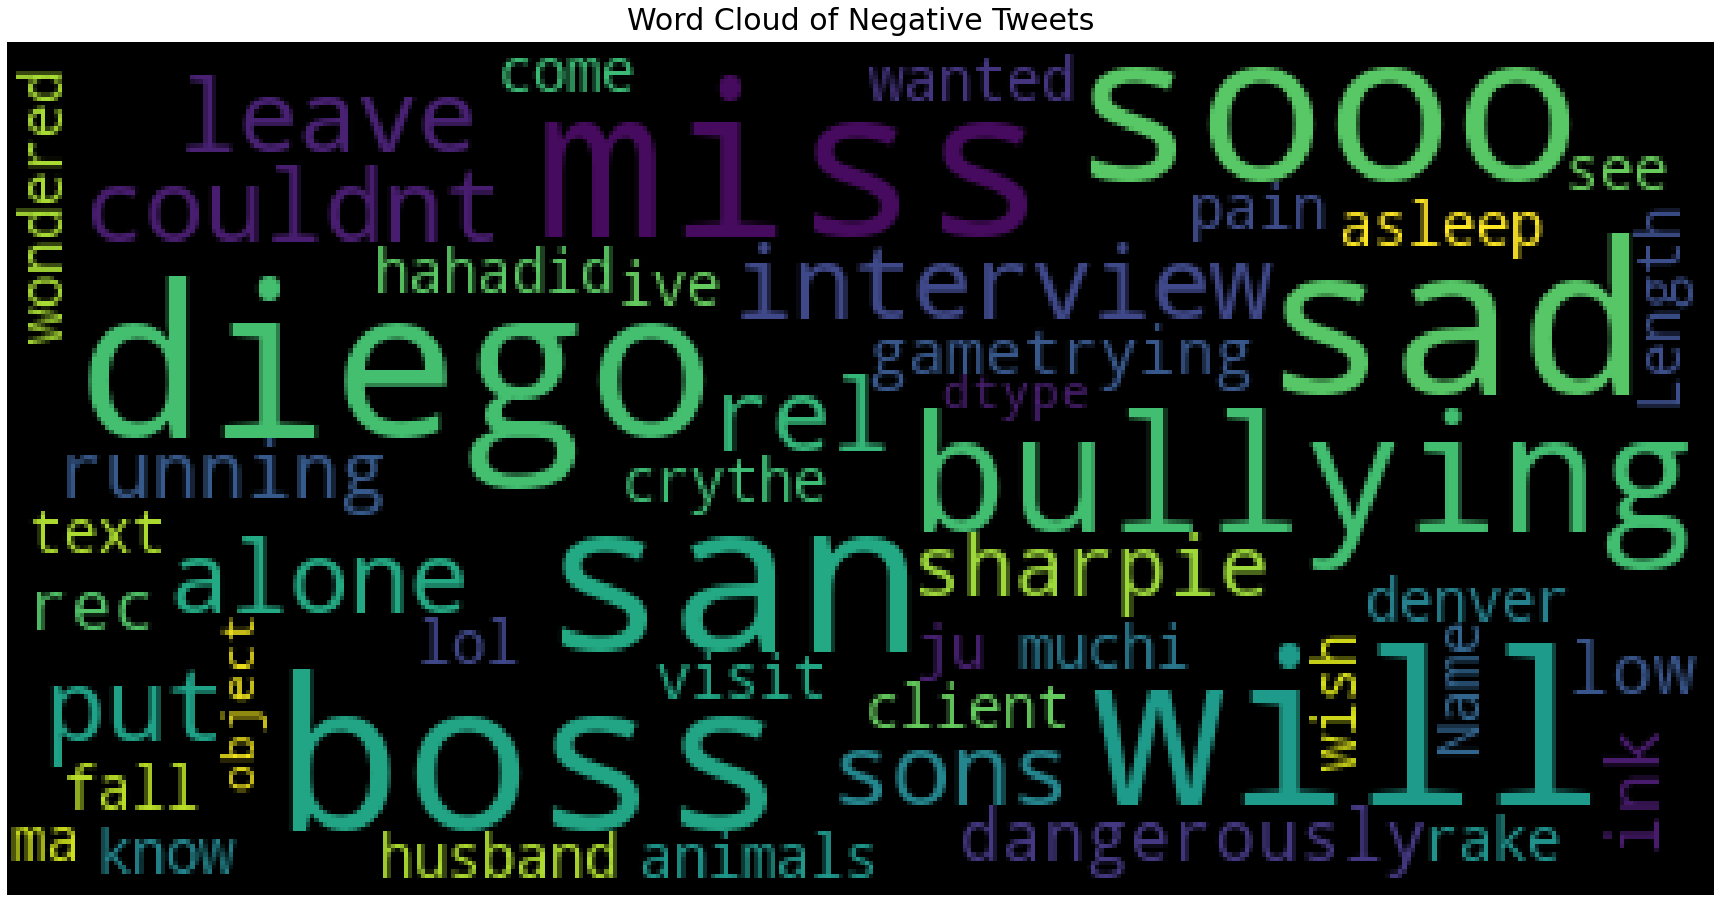

In [103]:
plot_wordcloud(Negative_sent.text,title="Word Cloud of Negative Tweets",color='black',max_font_size=50,title_size=30)

In [104]:
## Pipeline

#TextBlob’s word extraction feature from a sentence removes punctuations in an optimal level. The left out punctuations and other unusual notations will be removed in the upcoming preprocessing techniques.

In [105]:
tweet_test ='â #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in may   #blog #silver #gold #forex'

In [106]:
from textblob import TextBlob
nltk.download('punkt')

def form_sentence(tweet):
    tweet_blob = TextBlob(tweet)
    return ' '.join(tweet_blob.words)

print(df['text'].loc[10])
print(form_sentence(df['text'].loc[10]))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
 as much as i love to be hopeful i reckon the chances are minimal p im never gonna get my cake and stuff
as much as i love to be hopeful i reckon the chances are minimal p im never gon na get my cake and stuff


In an NLP task the stopwords (most common words e.g: is, are, have) do not make sense in learning because they don’t have connections with sentiments

In [107]:
def no_user_alpha(tweet):
    tweet_list = [ele for ele in tweet.split() if ele != 'user']
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess

print(df['text'].loc[10])
print(no_user_alpha(form_sentence(df['text'].loc[10])))

 as much as i love to be hopeful i reckon the chances are minimal p im never gonna get my cake and stuff
['much', 'love', 'hopeful', 'reckon', 'chances', 'minimal', 'p', 'im', 'never', 'gon', 'na', 'get', 'cake', 'stuff']


So we need to do Lexicon Normalization approach to solve this issue. NLTK’s built-in WordNetLemmatizer does this requirement.

In [108]:
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet
    
tweet_list = 'I was playing with my friends with whom I used to play, when you called me yesterday'.split()
print(normalization(tweet_list))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
['I', 'be', 'play', 'with', 'my', 'friends', 'with', 'whom', 'I', 'use', 'to', 'play,', 'when', 'you', 'call', 'me', 'yesterday']


## Modeling

In [109]:
pipe = Pipeline([
    ('bow',CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [110]:
msg_train, msg_test, label_train, label_test = train_test_split(df['text'], df['sentiment'], test_size=0.2)

pipe.fit(msg_train,label_train)
predictions = pipe.predict(msg_test)

print(classification_report(predictions,label_test))
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))

              precision    recall  f1-score   support

    negative       0.35      0.81      0.49       657
     neutral       0.87      0.52      0.66      3710
    positive       0.52      0.80      0.63      1129

    accuracy                           0.62      5496
   macro avg       0.58      0.71      0.59      5496
weighted avg       0.74      0.62      0.63      5496

[[ 535   92   30]
 [ 944 1946  820]
 [  35  190  904]]
0.6159024745269287


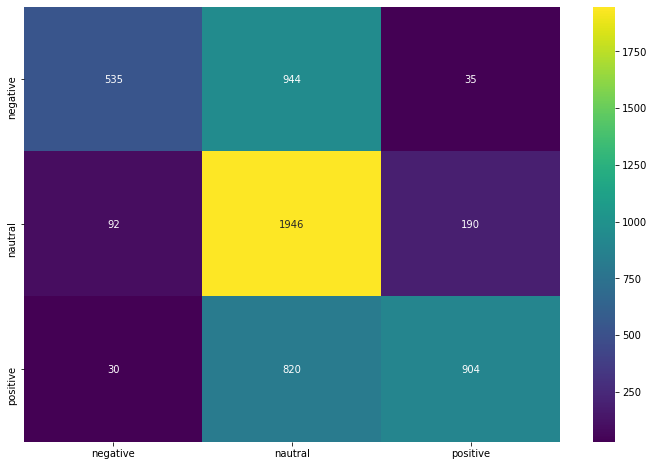

In [111]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
predictions = pipe.predict(msg_test)
cm = confusion_matrix(label_test, predictions)
labels = ['negative','nautral','positive']
sns.heatmap(cm,xticklabels=labels,yticklabels=labels,annot=True,fmt=".0f",cmap='viridis');

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/folks.jpg" width="1000">